# Import the ns3 source script

In [4]:
import sys
sys.path.append("../../ns3_sem")
import sem
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
ns_path = '../../ns3-dev-HOfailure_RACH'
script = 'hofailure_output'
campaign_dir = '../HOF_joiningtimeout_test'
campaign = sem.CampaignManager.new(ns_path, script, campaign_dir, overwrite=True)
print(campaign)

Building ns-3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| [00:06<00:00]

--- Campaign info ---
script: hofailure_output
params: {'simTime': 30.0, 'numberOfUes': 20.0, 'speed': 16.0, 'handoverAlgorithm': 'A2A4', 'Hysteresis': 3.0, 'TimeToTrigger': 256.0, 'ServingCellThreshold': 17.0, 'NeighbourCellOffset': 2.0}
HEAD: 8198095f90e12478089dae2da7cea9b08346f20c
Runner type: <class 'sem.parallelrunner.ParallelRunner'>
-----------


# Params

In [11]:
param_combination = {'simTime':30, 
                     'numberOfUes': 20, 
                     'speed':16.0,
                     'handoverAlgorithm': 'A3',
                     'Hysteresis': [i * 0.1 for i in range(0, 51)], 
                     'TimeToTrigger': 256.0,
                     'ServingCellThreshold': 20, #[j * 0.5 for j in range(0, 61)],
                     'NeighbourCellOffset':1.0,
                     'RngRun': [1]
                    }

# Running the simulation with the params

In [13]:
campaign.run_missing_simulations(param_combination, stop_on_errors=False)

# Summarize the result

In [14]:
def get_average_throughput(result):
    if result['output']['stderr'] != "":
        num_HOs = -1
        num_RLFs = -1
        num_HFMRs = -1
        num_HFNPs = -1
        num_HFJs = -1
        num_HFLs = -1
    else:
        split_results = result['output']['stdout'].split("\n")
        num_HOs = 0
        num_RLFs = 0
        num_HFMRs = 0
        num_HFNPs = 0
        num_HFJs = 0
        num_HFLs = 0
        for line in split_results:
            event = line.split(":")[0]
            if event == "HO_start":
                num_HOs += 1
            elif event == "Radio link failure detected":
                num_RLFs += 1
            elif event == "Handover Failure No Preamble":
                num_HFNPs += 1
            elif event == "Handover Failure Joiningtimeout":
                num_HFJs += 1
            elif event == "Handover Failure Max Rach":
                num_HFMRs += 1
            elif event == "Handover Failure Leaving":
                num_HFLs += 1
    return [num_HOs, num_RLFs, num_HFNPs, num_HFJs, num_HFMRs, num_HFLs]

# Generate dataframe of the result

In [15]:
results = campaign.get_results_as_dataframe(get_average_throughput, 
                                            ['Num_HOs', 'Num_RLFs','Num_HFNPs','Num_HFJs','Num_HFMRs','Num_HFLs'], 
                                            params = param_combination, drop_constant_columns=True)
print(results)

    Hysteresis  Num_HOs  Num_RLFs  Num_HFJs
0          0.0       42        16        24
1          0.1       42        16        24
2          0.2       42        16        24
3          0.3       43        17        22
4          0.4       43        17        22
5          0.5       43        17        22
6          0.6       43        17        22
7          0.7       43        17        22
8          0.8       40        22        16
9          0.9       40        22        16
10         1.0       40        22        16
11         1.1       40        22        16
12         1.2       40        22        16
13         1.3       40        22        16
14         1.4       40        22        16
15         1.5       40        22        16
16         1.6       40        22        16
17         1.7       40        22        16
18         1.8       40        22        16
19         1.9       40        22        16
20         2.0       40        22        16
21         2.1       40        2

# Plot the result

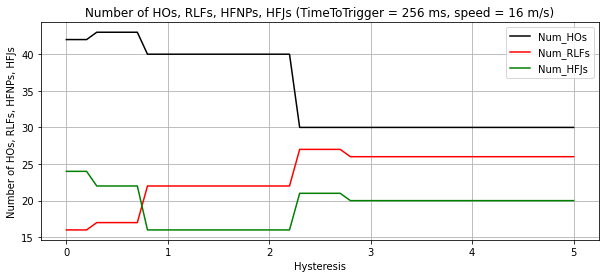

In [19]:
results_scThr = results
#results[(results['NeighbourCellOffset'] == 0.5)]
fig = plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.plot(results_scThr['Hysteresis'], results_scThr['Num_HOs'], color = 'black')
ax.plot(results_scThr['Hysteresis'], results_scThr['Num_RLFs'], color = 'red')
#ax.plot(results_scThr['Hysteresis'], results_scThr['Num_HFNPs'], color = 'blue')
ax.plot(results_scThr['Hysteresis'], results_scThr['Num_HFJs'], color = 'green')
ax.grid()
ax.set_xlabel('Hysteresis')
ax.set_ylabel('Number of HOs, RLFs, HFNPs, HFJs')
ax.set_title('Number of HOs, RLFs, HFNPs, HFJs (TimeToTrigger = 256 ms, speed = 16 m/s)')
ax.legend(['Num_HOs', 'Num_RLFs','Num_HFJs'])#'Num_HFNPs'